В данной домашке предлагается воспроизвести результаты статьи [ArXiv:2006.08545](https://arxiv.org/abs/2006.08545), изучающей поведение NF на Out-Of-Distribution (OOD) данных (т.е. тех данных, которые поток никогда не видел и которые находятся за пределом распределения обучающей выборки)

In [1]:
import os

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from tqdm.notebook import tqdm

In [2]:
import util

hyp_params = util.shell_util.DotDict({
    'batch_size': 128,
    'gpu_ids': [0, 1, 2, 3],
    'lr': 1e-3,
    'max_grad_norm': 1.0,
    'num_channels': 512,
    'num_levels': 3,
    'num_steps': 16,
    'num_epochs': 20,
    'num_samples': 64,
    'img_size': 32,
    'benchmark': True,
    'num_workers': 32,
    'resume': False,
    'seed': 18,
    'warm_up': 500000,
    'log_value': 10
})
hyp_params.batch_size *= max(1, len(hyp_params.gpu_ids))

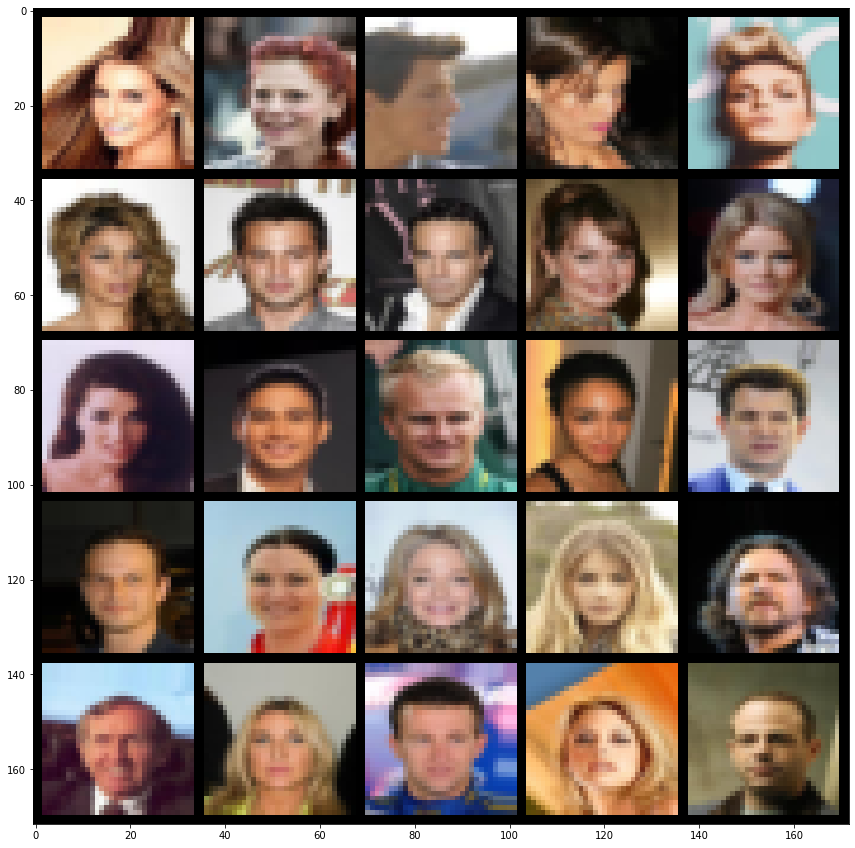

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

celeba_transforms = transforms.Compose([
    transforms.Resize((hyp_params.img_size, hyp_params.img_size)),
    transforms.ToTensor(),
])

full_dataset = torchvision.datasets.CelebA('./celeba/',
                                           transform=celeba_transforms,
                                           download=False)

dataloader = torch.utils.data.DataLoader(dataset=full_dataset,
                                         batch_size=hyp_params.batch_size,
                                         shuffle=True,
                                         drop_last=True)
train_size = int(len(full_dataset))
val_size = int(train_size * 0.1)
train_size = int(train_size * 0.9)
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

dataloader_train = torch.utils.data.DataLoader(train_dataset, hyp_params.batch_size, shuffle=True,
                                               num_workers=hyp_params.num_workers, drop_last=True)
dataloader_val = torch.utils.data.DataLoader(val_dataset, hyp_params.batch_size, shuffle=False,
                                             num_workers=hyp_params.num_workers, drop_last=True)

plt.figure(figsize=(15, 15))
plt.imshow(make_grid([full_dataset[i][0] for i in range(25)], nrow=5).permute(1, 2, 0))
plt.show()

## (0.3 балла) Обучить Glow на CelebA, добиться нормального качества генерируемых картинок

При невыполнении этого пункта все остальные пункты зануляются

In [36]:
import wandb

wandb.init(project='GLOW', reinit=True)

In [37]:
global_step = 0
best_loss = 0


@torch.enable_grad()
def train(epoch, net, trainloader, device, optimizer, scheduler, loss_fn, max_grad_norm):
    global global_step
    print(f'\nEpoch: {epoch}')
    net.train()
    loss_count = util.AverageMeter()
    for ind, (x, _) in tqdm(enumerate(trainloader), total=len(trainloader)):
        x = x.to(device)
        optimizer.zero_grad()
        z, sldj = net(x, reverse=False)
        loss = loss_fn(z, sldj)
        loss_count.update(loss.item(), x.size(0))
        loss.backward()
        if max_grad_norm > 0:
            util.clip_grad_norm(optimizer, max_grad_norm)
        optimizer.step()
        scheduler.step()

        if ind % hyp_params.log_value == 0:
            wandb.log({
                'Train/nll': loss_count.avg,
                'Train/bpd': util.bits_per_dim(x, loss_count.avg),
                'Train/lr': optimizer.param_groups[0]['lr']}
            )
            images = sample(net, hyp_params.num_samples, device).cpu()
            images_concat = make_grid(images)
            wandb.log({'Train/samples': [wandb.Image(images_concat, caption=f'epoch_{epoch}_ind_{ind}')]})
        global_step += x.size(0)


@torch.no_grad()
def sample(net, num_samples, device):
    z = torch.randn((num_samples, 3, hyp_params.img_size, hyp_params.img_size), dtype=torch.float32, device=device)
    x, _ = net(z, reverse=True)
    x = torch.sigmoid(x)

    return x


@torch.no_grad()
def test(epoch, net, testloader, device, loss_fn, num_samples):
    global best_loss
    net.eval()
    loss_count = util.AverageMeter()
    for x, _ in tqdm(testloader, total=len(testloader)):
        x = x.to(device)
        z, sldj = net(x, reverse=False)
        loss = loss_fn(z, sldj)
        loss_count.update(loss.item(), x.size(0))
        wandb.log({
            'Eval/nll': loss_count.avg,
            'Eval/bpd': util.bits_per_dim(x, loss_count.avg)
        })

    state = {
        'net': net.state_dict(),
        'epoch': epoch,
    }
    os.makedirs('ckpts', exist_ok=True)
    torch.save(state, f'ckpts/glow_epoch_{epoch}.pth')
    best_loss = loss_count.avg

    images = sample(net, num_samples, device).cpu()
    images_concat = make_grid(images)
    wandb.log({'Eval/samples': [wandb.Image(images_concat, caption=f'epoch_{epoch}')]})


In [4]:
import os
import random
import torch.optim as optim
import torch.optim.lr_scheduler as sched
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import util
from models import Glow

random.seed(hyp_params.seed)
np.random.seed(hyp_params.seed)
torch.manual_seed(hyp_params.seed)
torch.cuda.manual_seed_all(hyp_params.seed)

net = Glow(num_channels=hyp_params.num_channels,
           num_levels=hyp_params.num_levels,
           num_steps=hyp_params.num_steps)
net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net, hyp_params.gpu_ids)
    cudnn.benchmark = hyp_params.benchmark

start_epoch = 0
if hyp_params.resume:
    checkpoint = torch.load(f'ckpts/glow_epoch_{start_epoch}.pth')
    net.load_state_dict(checkpoint['net'])
    global best_loss
    global global_step
    start_epoch = checkpoint['epoch']
    global_step = start_epoch * len(dataloader_train)

loss_fn = util.NLLLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=hyp_params.lr)
scheduler = sched.LambdaLR(optimizer, lambda s: min(1., s / hyp_params.warm_up))

for epoch in range(start_epoch, start_epoch + hyp_params.num_epochs):
    train(epoch, net, dataloader_train, device, optimizer, scheduler,
          loss_fn, hyp_params.max_grad_norm)
    test(epoch, net, dataloader_val, device, loss_fn, hyp_params.num_samples)

In [ ]:
state = {
    'net': net.state_dict(),
    'epoch': epoch,
}
os.makedirs('ckpts', exist_ok=True)
torch.save(state, f'ckpts/glow_epoch_{epoch}.pth')

In [5]:
start_epoch = 22
checkpoint = torch.load(f'ckpts/glow_epoch_{start_epoch}.pth')
net.load_state_dict(checkpoint['net'])

<All keys matched successfully>

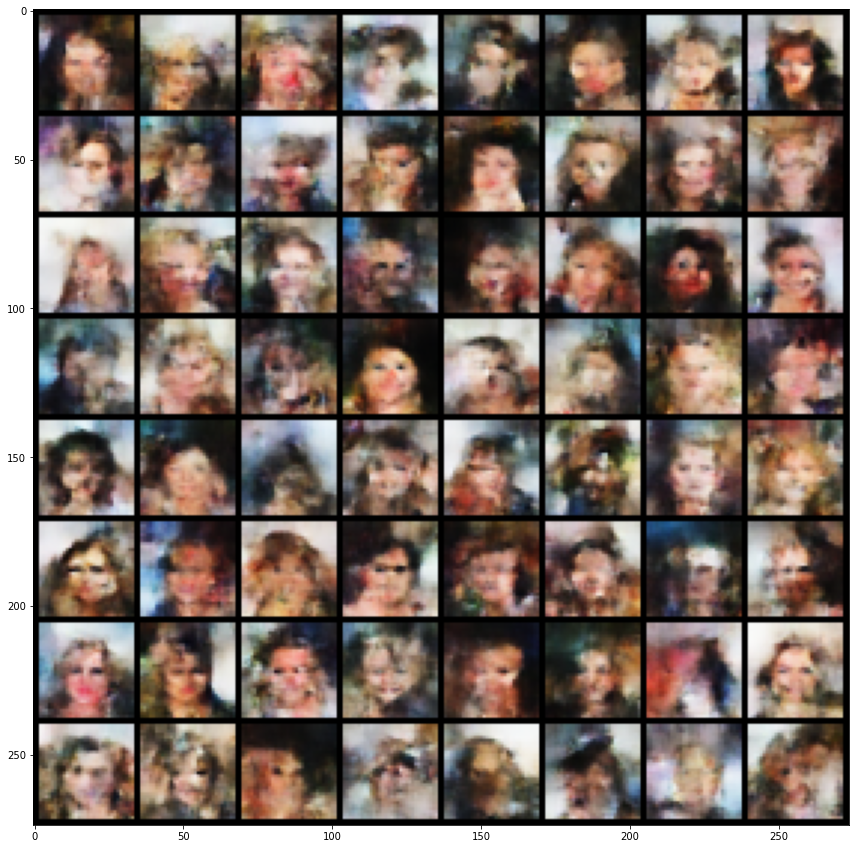

In [38]:
images = sample(net, hyp_params.num_samples, device).cpu()
images_concat = make_grid(images)

plt.figure(figsize=(15, 15))
plt.imshow(images_concat.permute(1, 2, 0))
plt.show()

## (0.4 балла) Построить гистограмму лайклихудов для обученного в предыдущем пункте потока для данных CelebA (train), CelebA (test) и SVHN (OOD)
Замечание: из каждого датасета достаточно взять только некоторую долю объектов, достаточную для построения гистограммы 

In [7]:
def standard_normal_logprob(z):
    return (-np.log(2 * np.pi) - 0.5 * z.pow(2)).sum(1, keepdim=True)

In [9]:
svhn_dataset = torchvision.datasets.SVHN(root='./SVHN/',
                                         transform=celeba_transforms,
                                         download=True)

dataloader_svhn = torch.utils.data.DataLoader(dataset=svhn_dataset,
                                              batch_size=16,
                                              shuffle=True,
                                              drop_last=True)

dataloader_train = torch.utils.data.DataLoader(train_dataset, 16, shuffle=True,
                                               num_workers=hyp_params.num_workers, drop_last=True)

dataloader_val = torch.utils.data.DataLoader(val_dataset, 16, shuffle=False,
                                             num_workers=hyp_params.num_workers, drop_last=True)

Using downloaded and verified file: ./SVHN/train_32x32.mat


In [30]:
likelyhoods_train = list()
for idx, (x, _) in tqdm(enumerate(dataloader_train), total=hyp_params.num_samples):
    x.to(device)
    if idx > hyp_params.num_samples - 1:
        break
    z, _ = net(x)
    likelyhoods_train.append(standard_normal_logprob(z).mean(axis=(2, 3)).squeeze().cpu().detach().numpy())

likelyhoods_test = list()
for idx, (x, _) in tqdm(enumerate(dataloader_val), total=hyp_params.num_samples):
    x.to(device)
    if idx > hyp_params.num_samples - 1:
        break
    z, _ = net(x)
    likelyhoods_test.append(standard_normal_logprob(z).mean(axis=(2, 3)).squeeze().cpu().detach().numpy())

likelyhoods_svhn = list()
for idx, (x, _) in tqdm(enumerate(dataloader_svhn), total=hyp_params.num_samples):
    x.to(device)
    if idx > hyp_params.num_samples - 1:
        break
    z, _ = net(x)
    likelyhoods_svhn.append(standard_normal_logprob(z).mean(axis=(2, 3)).squeeze().cpu().detach().numpy())

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

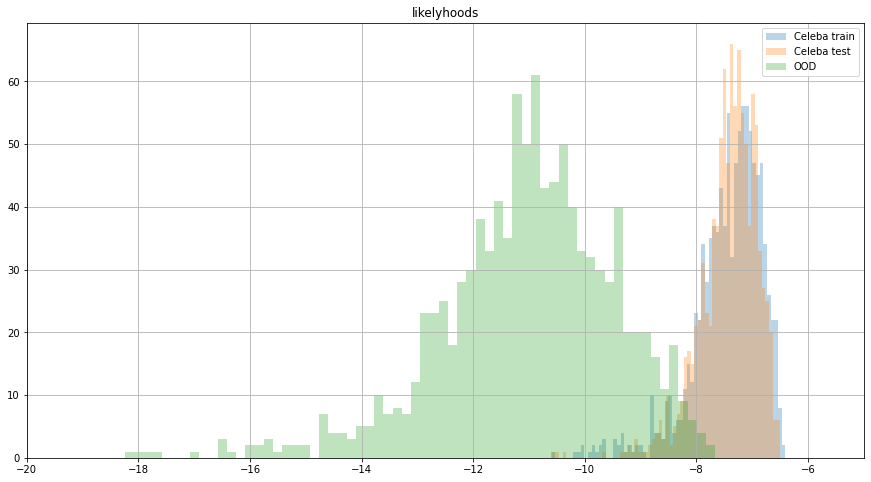

In [31]:
# preprocess = lambda x: [elem.detach().numpy() for elem in x]
l_plot_train = np.array(likelyhoods_train).reshape(-1)
l_plot_test = np.array(likelyhoods_test).reshape(-1)
l_plot_ood = np.array(likelyhoods_svhn).reshape(-1)

plt.figure(figsize=(15, 8))
plt.title('likelyhoods')

plt.xlim(-20, -5)
plt.hist(l_plot_train, bins=hyp_params.num_samples, label='Celeba train', alpha=0.3)
plt.hist(l_plot_test, bins=hyp_params.num_samples, label='Celeba test', alpha=0.3)
plt.hist(l_plot_ood, bins=hyp_params.num_samples, label='OOD', alpha=0.3)

plt.grid()
plt.legend()
plt.show()

## (0.3 балла) Сравнить картинки из OOD (SVHN) с наибольшим предсказанным лайклихудом с картинками обучающего датасета (CelebA) с наименьшим лайклихудом. Что можно сказать об этих картинках? Почему лайклихуд первых может быть выше?

In [32]:
images = []
images_bad = []
for idx, (x, _) in tqdm(enumerate(dataloader_svhn), total=hyp_params.num_samples):
    x.to(device)
    if idx > hyp_params.num_samples - 1:
        break
    z, _ = net(x)
    ls = standard_normal_logprob(z).mean(axis=(2, 3)).squeeze()
    images.append(x[torch.argmax(ls)])
    images_bad.append(x[torch.argmin(ls)])

  0%|          | 0/64 [00:00<?, ?it/s]

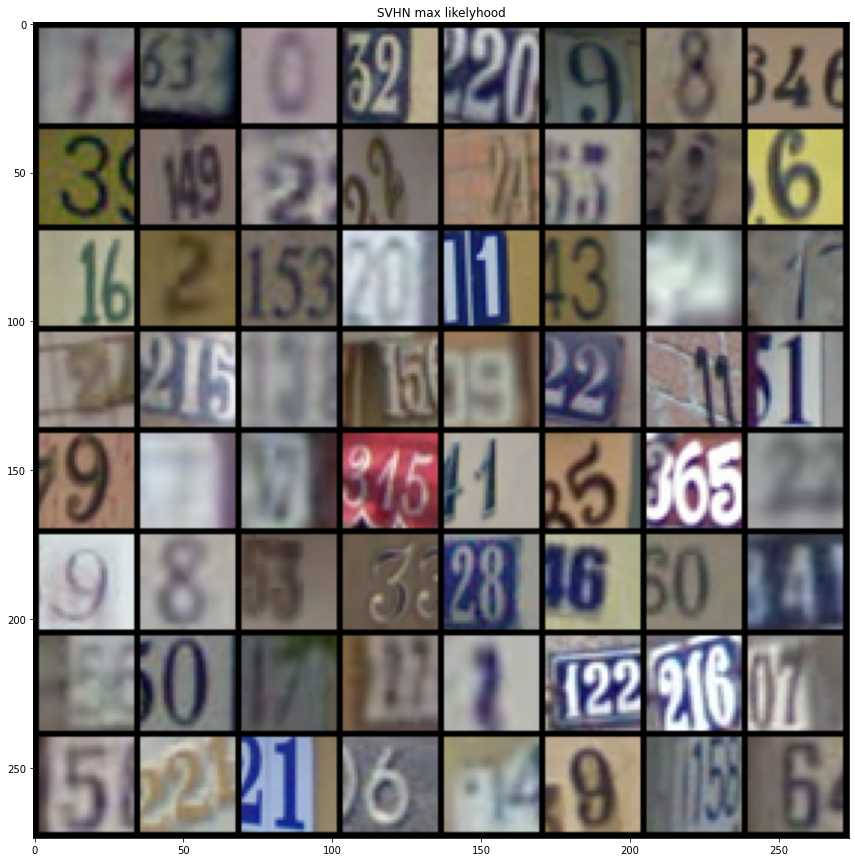

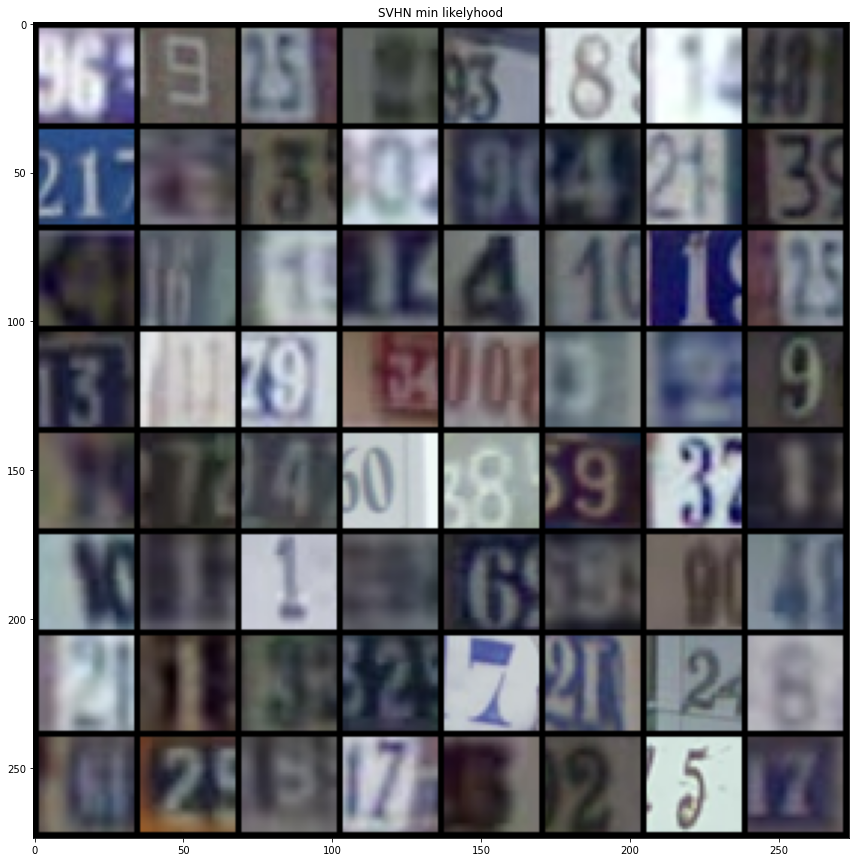

In [33]:
plt.figure(figsize=(15, 15))
plt.title('SVHN max likelyhood')
plt.imshow(make_grid(images).permute(1, 2, 0))
plt.show()

plt.figure(figsize=(15, 15))
plt.title('SVHN min likelyhood')
plt.imshow(make_grid(images_bad).permute(1, 2, 0))
plt.show()

In [34]:
images = []
images_bad = []
for idx, (x, _) in tqdm(enumerate(dataloader_train), total=hyp_params.num_samples):
    x.to(device)
    if idx > hyp_params.num_samples - 1:
        break
    z, _ = net(x)
    ls = standard_normal_logprob(z).mean(axis=(2, 3)).squeeze()
    images.append(x[torch.argmax(ls)])
    images_bad.append(x[torch.argmin(ls)])

  0%|          | 0/64 [00:00<?, ?it/s]

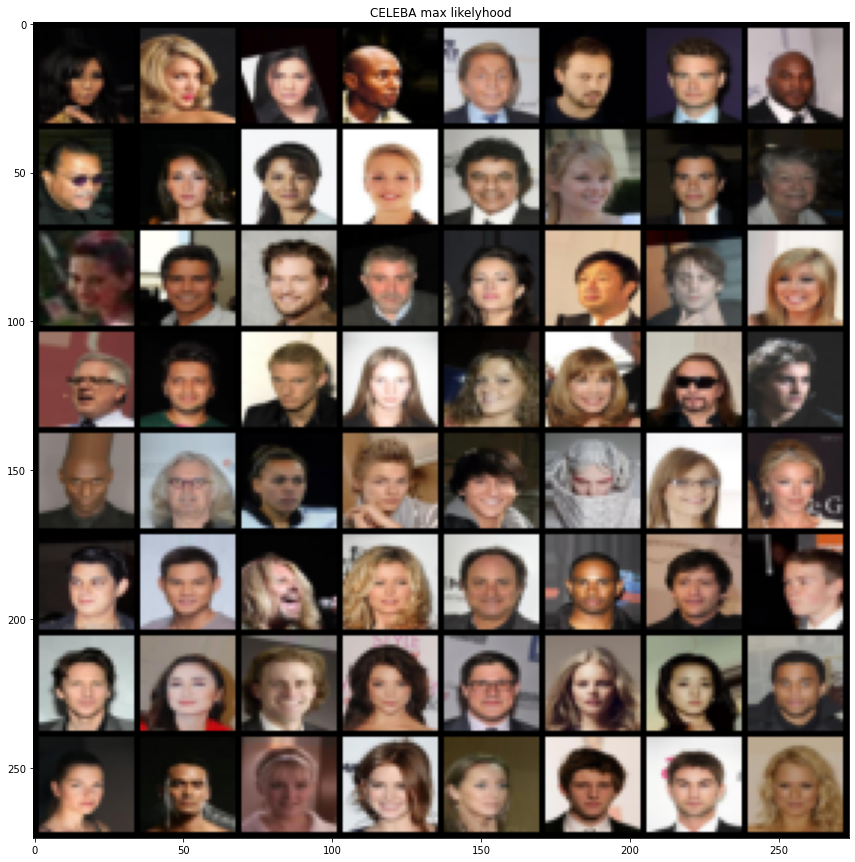

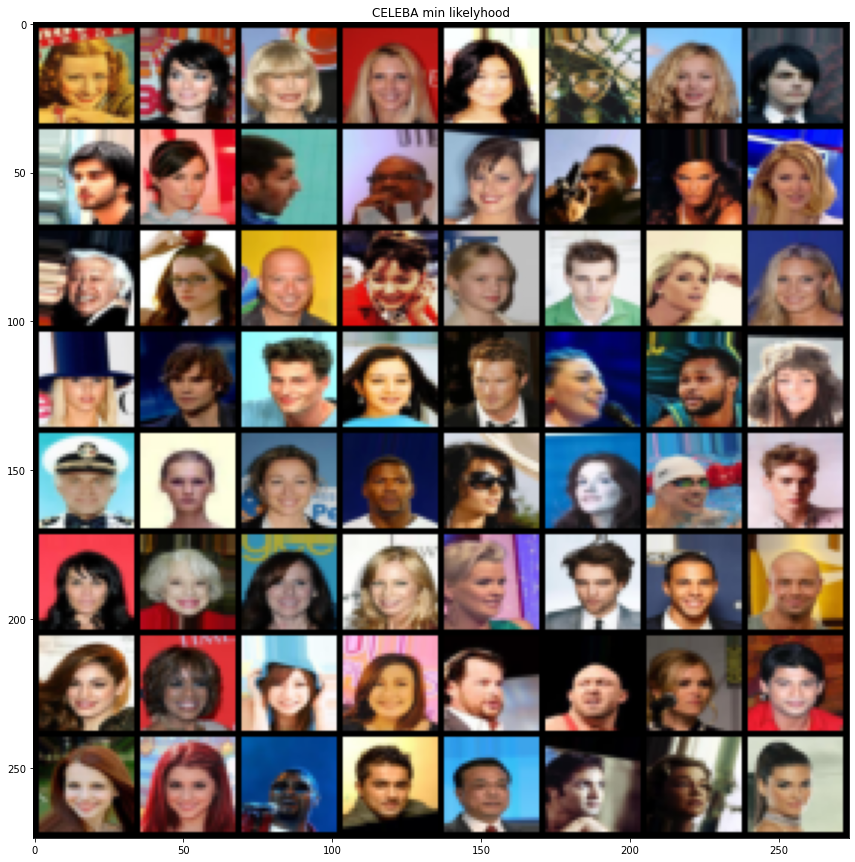

In [35]:
plt.figure(figsize=(15, 15))
plt.title('CELEBA max likelyhood')
plt.imshow(make_grid(images).permute(1, 2, 0))
plt.show()

plt.figure(figsize=(15, 15))
plt.title('CELEBA min likelyhood')
plt.imshow(make_grid(images_bad).permute(1, 2, 0))
plt.show()

#### Как видно, в случае наибольшего предсказанного лайклихуда, на датасете SVHN цифры на картинках более четкие и различимы, нежели в случае наименьшего лайклихуда. На датасете CELEBA, в первом случае фон в более нейтральных цветах (во втором случае очень яркие и контрастные цвета), у людей нет головных уборов и очков, нет поворотов головы, в сравнении с наименьшим лайклихудом. Лайклихуд выше, потому что объекты больше похожи друг на друга (celeba - одинаковый/похожий фон, SVHN - четкие символы и фон больше похож как на картинках celeba)